In [2]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "ch05", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

/Users/young/project/llmProject/LLMs-from-scratch-CN/ch05/01_main-chapter-code


## 5.1 评估文本生成大模型

### 5.1.1 用GPT来生成文本

In [3]:
import torch
from previous_chapters import GPTModel

# 124M模型配置
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
# 预测模式，dropout层不起作用
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

# text -> ids
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

# ids -> text
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

# 生成文本测试
start_context = "Every effort moves you"
# 使用gpt2的tokenizer
tokenizer = tiktoken.get_encoding("gpt2")
# 将文本转换为token ids, 并输入模型
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    # 生成10个新token
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
# 将模型结果ids转换为文本
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.2 计算文本生成的损失：交叉熵(cross-entropy)和困惑度（perplexity）

In [6]:
# 构建一组测试输入和目标，以ids list的形式表式
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [7]:
# 计算当前inputs的预测的下一个token的概率
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
# 当输入的shape为[2, 3, 50257]时，对于每个输入的每个token，预测下一个token的概率
# 由于使用了causal mask，每个token的预测只依赖于它前面的token
print(probas.shape)

torch.Size([2, 3, 50257])


In [8]:
# 取max，得到预测的下一个token
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [9]:
# 将预测的ids转换为文本，与targets对比
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [25]:
# 查看当前样本的targets的概率
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [26]:
# 计算对数概率
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [27]:
# 计算平均对数概率
# 在对数概率下，越接近0，表示预测越准确
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [28]:
# 负平均对数概率, 即交叉熵损失
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [29]:
# 查看logits和targets的shape
# (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)
# (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [30]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [31]:
# 使用torch的cross_entropy计算交叉熵损失
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
# 与neg_avg_log_probas相同
print(loss)

tensor(10.7940)


In [32]:
# 计算困惑度, 困惑度是交叉熵的指数
perplexity = torch.exp(loss)
# 困惑度越小，表示预测越准确
print(perplexity)

tensor(48725.8203)


### 5.1.3 计算训练集和验证集的损失

In [34]:
# 下载训练数据
import os 
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode("utf-8")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [35]:
# 查看文本数据
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [38]:
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [39]:
# 统计文本长度及编码后的token个数
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [40]:
# 构建dataloader
from previous_chapters import create_dataloader_v1

# 划分训练集和验证集
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

# 训练集
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

# 验证集
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [41]:
# 快速检测(sanity check)
# 检查训练集和验证集的token个数是否足够
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [42]:
# 确认数据导入成功
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [43]:
# 另一个方式，确认数据导入成功
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()
print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [47]:
# 计算batch loss
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# 计算数据集的loss
def calc_loss_loader(data_loader, model ,device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [48]:
# 若有GPU，则使用GPU计算
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [46]:
# 注意：
# 如果取消注释以下代码块，代码可以在 Apple Silicon 芯片上运行（如果适用），
# 在 M3 MacBook Air 上测量速度大约是 Apple CPU 的两倍。
# 然而，计算得到的损失值可能会略有不同。
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
   train_loss = calc_loss_loader(train_loader, model, device)
   val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Using mps device.
Training loss: 10.987583054436577
Validation loss: 10.98110580444336


## 5.2 训练大语言模型

In [54]:
def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    # training loop
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        for input_batch, target_batch in train_loader:
            # 梯度清零
            optimizer.zero_grad()
            # 计算batch loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 更新token计数
            tokens_seen += input_batch.numel()
            # 更新全局步数
            global_step += 1
            # 每eval_freq个batch，计算一次loss, 查看训练效果
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                # 记录loss
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                # 记录token计数
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每个epoch结束，生成和打印文本
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

# 模型评估
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# 生成和打印文本
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [55]:
# 训练模型
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
# 定义优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
# 训练模型
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
print(f"Total training time: {(end_time - start_time) / 60:.2f} minutes")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

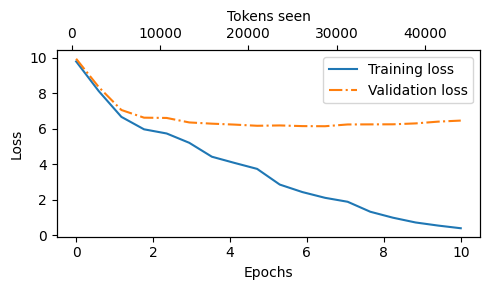

In [56]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 绘制Loss
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)